# Locality-Sensitive Hashing 

## 1. Introduction

Locality Sensitive Hashing (LSH) is a class of hash functions that hash similar inputs into similar bucket with the premises of a similarity measure inthe inputs vectors. LSH is crucial in many applications and the most prominent one is that it enables sublinear-time in number of data points for nearest neigbor search.

This project explore the earlier idea of Andoni's **Spherical LSH**, a simplified LSH-style method that hashes unit-normalized vectors into spherical caps (buckets) based on their dot product with random Gaussian vectors. **Spherical LSH** is then adapted to enable the better **Optimal Data-Dependent Hashing**. **Spherical LSH** has been well studys and it has tight bound for its qury time and space. For Eucliean space, it has query time comlexity $O(d \cdot n^{\rho})$ and query space complextiy $O(d \cdot n^{\rho +1} + dn)$ for $\rho = 1/c^2$ for $c > 1$ (typically $c = 2$). 

In this project, we focus on applying **Spherical LSH to real-world data**—specifically, university course descriptions. We implement a simplified version of Spherical LSH (CapCarvingLSH), evaluate it empirically, and aim to:

- Build intuition for the theoretical bounds presented in the literature  
- Understand the tradeoffs between accuracy and efficiency  
- Compare its performance to practical baselines like FAISS and naive Nearest Neighborimplementation in both speed and quality

## 2. Background and Related Work

Let `n` denote the number of data points and `d` the dimensionality of each vector (e.g., sentence embeddings). The approximate nearest neighbor (ANN) problem aims to quickly retrieve the most similar vector to a given query, ideally with sublinear dependence on `n`.

### Evolution of ANN Algorithms

**Locality Sensitive Hashing (LSH)** [Indyk and Motwani, 1998] is one of the earliest and most foundational approaches for ANN. Its key insight is to design hash functions such that similar points are more likely to collide (i.e., fall into the same bucket). This enables sublinear query time in `n`, at the cost of some accuracy.

**Optimal Data-Dependent Hashing** [Andoni et al., 2015] improves upon classical LSH by learning better partitions based on data geometry. Their work introduced **Spherical LSH** combined with tree-based search to push query times even lower in practice.

More recently, **Hierarchical Navigable Small World (HNSW)** graphs [Malkov and Yashunin, 2018] introduced a proximity-graph-based structure with multiple layers, allowing greedy logarithmic-time traversal while maintaining high recall.


---

### Theoretical Query Time Comparison

| Method            | Query Time Complexity | Notes                                                                 |
|-------------------|------------------------|-----------------------------------------------------------------------|
| **FAISS (Flat)**  | $O(n \cdot d)$         | Exact search using brute-force; high accuracy but poor scalability.  |
| **HNSW**          | $O(\log n \cdot d)$    | Graph-based; strong empirical recall and fast queries.                |
| **CapCarvingLSH** | $O(n^\rho \cdot d)$    | $\rho < 1$ depends on bucket selectivity; analyzed further in §4.    |

---

While traditional LSH offers elegant sublinear time bounds, this project focuses on its **empirical behavior** on real-world semantic data and see intuitions of the theoretical bounds.

## 3. Experimental Setup

We use the **Cornell course descriptions** dataset, which contains 3,094 courses. To remove redundancy, we first clean the data by **merging cross-listed courses** that share identical descriptions.

Each course description is then embedded into a high-dimensional semantic space using a sentence transformer. The result is a vector $v \in \mathbb{R}^d$, which we normalize to lie on the unit hypersphere $S^{d-1}$. This means each embedding satisfies:

$$
v \in S^{d-1} \quad \text{such that} \quad \|v\| = 1
$$

To explore the behavior of locality-sensitive hashing, we implement a simplified version of **Spherical LSH**, which we call **CapCarvingLSH**. The idea is to carve the unit sphere into regions (spherical caps) using random Gaussian vectors. Each cap acts as a hash bucket: embeddings that fall into the same cap are considered similar.

We then compare the empirical performance of CapCarvingLSH against well-established baselines such as **FAISS** and Nearest Neighbor. 

All alogrithms would be tested on course descriptions queries and we monitor Spherical LSH's accucary, run time, and space usage. We also include customs description to get a sense of how Spherical LSH performance.

In [467]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import hnswlib
import faiss
from datasketch import MinHash, MinHashLSH
import time
import os
import psutil
import threading
import random

from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

### 3.1 Load Data

#### 3.1.1 Data Cleaning

Here, we load the provided data and process it such that those courses that are cross-listed are combined to one class in the data frame. This is necessary when later we calculate the accurary of the LSH functions.

In [468]:
def load_data(path):
    df = pd.read_csv(path, sep='\t')
    df.dropna(subset=['Description'], inplace=True)
    df['CourseID'] = df['Subject'] + ' ' + df['Course Number'].astype(str)
    df = df.groupby('Description', as_index=False).agg({
        'CourseID': lambda x: ', '.join(sorted(set(x)))
    })
    return df[['CourseID', 'Description']]

In [469]:
df = load_data('acd.tsv')

In [470]:
df

,CourseID,Description
0,PE 1265,&quot;Here&#039;s to a Healthier You&quot; - A...
1,"ENGL 4405, FGSS 4405, PMA 4605",&quot;I was a man who stood in symbolic relati...
2,"COML 3550, ENGL 3550, FGSS 3550, LGBT 3550","&quot;My existence is a scandal,&quot; Oscar W..."
3,UNILWYL 1416,&quot;Socially Just Leadership Development&quo...
4,PAM 6950,&quot;Spatial Demography&quot; introduces core...
...,...,...
3089,PHYS 3310,Would you find it appealing to operate a physi...
3090,ENGL 3890,Writers of creative nonfiction plumb the depth...
3091,PSYCH 2801,Writing in the Majors section of PSYCH 2800. I...
3092,NBA 5710,"You&#039;ve learned finance, marketing, operat..."


#### 3.1.2 Sentence Embeddings

To study the effect of embedding dimensionality on similarity search performance, we generate two sets of course description embeddings:

- One using a **lower-dimensional** model with $d = 384$ dimensions  
  (e.g., `all-MiniLM-L6-v2`)

- Another using a **higher-dimensional** model with $d = 768$ dimensions  
  (e.g., `all-mpnet-base-v2`)

This allows us to compare how different ANN methods behave under increased feature richness and potential overfitting or redundancy in high-dimensional space.


In [471]:
def embed_descriptions(descriptions, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(descriptions.tolist(), show_progress_bar=True)
    return np.array(embeddings), model

In [472]:
embeddings, model = embed_descriptions(df['Description'])

Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:06<00:00, 14.21it/s]


In [356]:
higher_embeddings, higher_model = embed_descriptions(df['Description'], model_name ='all-mpnet-base-v2' )

Batches: 100%|████████████████████████████████████████| 97/97 [01:33<00:00,  1.03it/s]


In [357]:
print(embeddings.shape)
print(higher_embeddings.shape)

(3094, 384)
(3094, 768)


We verify that the embeddings has norm of 1.

In [604]:
np.linalg.norm(embeddings[0])

np.float32(1.0)

## 4 Implementation Details

### 4.1 LSH Implementation

#### 4.1.1 Spherical LSH

Let $\mathcal{R} \leftarrow \emptyset$

**while** $\bigcup \mathcal{R} \ne \mathbb{S}^{d-1}$ **do**
- Sample $g \sim \mathcal{N}(0, 1)^d$
- Let $U \leftarrow \left\{ u \in \mathbb{S}^{d-1} : \langle u, g \rangle \ge d^{1/4} \right\} \setminus \bigcup \mathcal{R}$
- **if** $U \ne \emptyset$ **then**
  - $\mathcal{R} \leftarrow \mathcal{R} \cup \{ U \}$


Although there is a gitrepo implemented by Andoni, last time it was updated was 9 years ago. I spent some time trying to complied it but failed. 

Thus, I implemented the Spherical LSH from the [Andoni 15] paper myself.

Notice that the original Spherical LSH Algorithm parition the points when $\langle u, g \rangle \ge d^{1/4}$. I find the ${1/4}$ on the exponent too strict in my implementation (there are optimizations that find a Spherical LSH parition fast but due to the limited time, I didn't implement it). The exact ${1/4}$ on the exponent takes a long time to find a Spherical LSH parition so I loosen the constraint to $\leq0.25$ so that it can find an approximate Spherical LSH and it works well in this project.

In [408]:
class CapCarvingLSH:
    def __init__(self, dim=128, threshold_exp=0.25, max_iterations=5000):
        self.dim = dim
        self.max_iterations = max_iterations
        self.threshold = dim ** threshold_exp
        self.buckets = []
        self.partitions = []
        

    def index(self, data):
        buckets = []
        partitions = []
        assigned = set()

        cur_set = []
        i = 0
        iterations = 0
        
        while iterations < self.max_iterations and len(assigned) < len(data):
            cur_set = []
            g = np.random.randn(self.dim)

            for idx, vec in enumerate(data):
                if idx not in assigned:
                    if np.dot(g, vec) >= self.threshold:
                        cur_set.append(idx)
                        assigned.add(idx)
                        
            if len(cur_set) > 0:
                buckets.append(cur_set)
                partitions.append(g)

            iterations += 1
            
        self.buckets = buckets
        self.partitions = partitions
        print("number of partitions generated: ", len(self.buckets))
                
                
    def query(self, q):
        for i, g in enumerate(self.partitions):
            if np.dot(g, q) >= self.threshold:
                return self.buckets[i]
        return []


#### 4.1.2  Baseline 

We also include **FAISS IndexFlatL2** and **Naive NN** as baselines to compare with **LSH**

In [605]:
def build_capcarving_index(embeddings):
    dim=embeddings.shape[1]
    cclsh = CapCarvingLSH(dim=dim, threshold_exp = 0.2, max_iterations = 5000)
    cclsh.index(embeddings)
    return cclsh

def build_faiss_exact_l2_index(embeddings):
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)  
    index.add(embeddings)          
    return index

def naive_nn_search(query, data, k=1):
    # Compute squared L2 distances to all points
    dists = np.linalg.norm(data - query, axis=1)
    
    # Get indices of the k smallest distances
    indices = np.argsort(dists)[:k]
    return indices, dists[indices]

#### 4.1.3 Comparison of Above Implemetations



To evaluate the performance of **Spherical LSH**, we compare it against two other methods that also use Euclidean distance:

- **Naive Nearest Neighbor**: Brute-force linear scan
- **FAISS's `IndexFlatL2`**: Optimized exact search using L2 distance

We summarize their **time and space complexity** below:

| Method              | Exact? | Build Time         | Query Time (per query) | Space Complexity     | Notes |
|---------------------|--------|---------------------|-------------------------|-----------------------|-------|
| **Naive NN**         | Yes | `O(1)`              | `O(n × d)`              | `O(n × d)`            | Simple, slow for large `n` |
| **FAISS IndexFlatL2**| Yes | `O(1)`              | `O(n × d)` (fast C++/SIMD)| `O(n × d)`         | Optimized brute-force |
| **Spherical LSH**    | No  | `O(n × L × d)`      | `O(L × d)`               | `O(L × n)`           | Fast if `L` and bucket size `b` are small |

> - `n`: number of vectors  
> - `d`: dimension of each vector  
> - `L`: number of buckets tables in LSH  

While both FAISS and Naive NN give exact results, **Spherical LSH** trades off some accuracy for much faster query time in high dimensions, depending on how well the hashing captures angular or Euclidean similarity.


We also notice that our implementaion takes a long time to find the hash paritions. There are more **optimalized implementations** but we use the current one for the sake of time.

### 4.2 Measuring Indexing Time and Memory Usage

To fairly compare different nearest neighbor indexing methods (e.g., **FAISS** and **CapCarving**), we define a utility function that measures:

- **Wall-clock time** to build the index
- **Delta memory**: the change in memory usage from start to finish
- **Peak memory usage**: the highest memory usage during the operation





In [362]:
def measure_indexing_memory_and_time(func, *args, **kwargs):
    process = psutil.Process(os.getpid())
    start_mem = process.memory_info().rss / (1024 ** 2)  # MB
    peak_memory = [start_mem]

    def monitor():
        while not stop_monitor.is_set():
            mem = process.memory_info().rss / (1024 ** 2)
            peak_memory[0] = max(peak_memory[0], mem)
            time.sleep(0.01)

    stop_monitor = threading.Event()
    monitor_thread = threading.Thread(target=monitor)
    monitor_thread.start()

    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time

    stop_monitor.set()
    monitor_thread.join()

    end_mem = process.memory_info().rss / (1024 ** 2)  # MB
    delta_mem = end_mem - start_mem
    return result, elapsed_time, delta_mem, peak_memory[0]

#### 4.2.1 Time and Space to Build Spherical LSH

We observe that using our implementation, it takes significant time to find a LSH hash function even with loosened contraints. Later, we will show that a better approximation of LSH hash function would lead to faster empirical query time.

Time and memory used for building LSH with $d = 384$

In [546]:
faiss_l2_index, faiss_l2_time, faiss_l2_delta, faiss_l2_peak = measure_indexing_memory_and_time(build_faiss_exact_l2_index, embeddings.copy())
cap_index, cap_time, cap_delta, cap_peak = measure_indexing_memory_and_time(build_capcarving_index, embeddings.copy())

print(f"FAISS:       Time = {faiss_l2_time:.2f}s, ΔMemory = {faiss_l2_delta:.2f} MB, Peak = {faiss_l2_peak:.2f} MB")
print(f"CapCarving:  Time = {cap_time:.2f}s, ΔMemory = {cap_delta:.2f} MB, Peak = {cap_peak:.2f} MB")

number of partitions generated:  1125
FAISS:       Time = 0.00s, ΔMemory = 5.59 MB, Peak = 186.41 MB
CapCarving:  Time = 3.87s, ΔMemory = 6.81 MB, Peak = 198.06 MB


Time and memory used for building LSH with $d = 768$

In [376]:
h_faiss_l2_index, h_faiss_l2_time, h_faiss_l2_delta, h_faiss_l2_peak = measure_indexing_memory_and_time(build_faiss_exact_l2_index, higher_embedding.copy())
h_cap_index, h_cap_time, h_cap_delta, h_cap_peak = measure_indexing_memory_and_time(build_capcarving_index, higher_embeddings.copy())

print(f"FAISS:       Time = {h_faiss_l2_time:.2f}s, ΔMemory = {h_faiss_l2_delta:.2f} MB, Peak = {h_faiss_l2_peak:.2f} MB")
print(f"CapCarving:  Time = {h_cap_time:.2f}s, ΔMemory = {h_cap_delta:.2f} MB, Peak = {h_cap_peak:.2f} MB")

number of partitions generated:  458
FAISS:       Time = 0.01s, ΔMemory = 9.08 MB, Peak = 207.30 MB
CapCarving:  Time = 19.98s, ΔMemory = -29.25 MB, Peak = 236.77 MB


We also observe that the **time needed to find a spherical LSH scale superlinearly in $d$** as it is harder to find paritions for data points in higher dimensions.

### 4.3 Spherical LSH performance in queries

We would test the performance of LSH on queries of both exisiting descriptions of the class and custom descriptions and then observe the different NN algorithm perforcemance.

Load the custom descriptions

In [477]:
test_df = pd.read_csv("course_descriptions.csv")
test_embeddings = model.encode(test_df["description"].tolist(), show_progress_bar=True)

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.15it/s]


In [597]:
def evaluate_queries(index, sample_indices, embeddings, method, df=None, top_k = 5, num_test_queries = 10, show_res = False, test = False, test_embeddings = None, test_df = None):
    process = psutil.Process(os.getpid())
    total_time = 0
    total_memory = 0
    if test:
        embeddings = test_embeddings

    for idx in sample_indices:
        query_vec = np.expand_dims(embeddings[idx], axis=0)

        m0 = process.memory_info().rss / (1024 ** 2)
        start = time.time()

        if method == 'faiss':
            faiss.normalize_L2(query_vec)
            _, results = index.search(query_vec, k = top_k)
        elif method == 'capcarving':
            results = index.query(query_vec[0])
        elif method == 'naive':
            results = naive_nn_search(query_vec, embeddings, k=top_k)
        else:
             raise ValueError("Unknown method")
            
        elapsed = time.time() - start
        m1 = process.memory_info().rss / (1024 ** 2)

        total_time += elapsed
        total_memory += (m1 - m0)

        if show_res:
            if test:
                print(f"Query [{method.upper()}]  {test_df.iloc[idx]['description'][:60]}...")
            else:
                print(f"Query [{method.upper()}] [{df.iloc[idx]['CourseID']}]: {df.iloc[idx]['Description'][:60]}...")
        
            top_ids = results[:5] if isinstance(results, list) else results[0][:5]
            print(df.iloc[top_ids][['CourseID']])
            print("-------------------------------------------------")

    avg_time = total_time / num_test_queries
    avg_mem = total_memory / num_test_queries
    return avg_time, avg_mem

In [598]:
def get_time_mem_stats(num_test_queries, embeddings, faiss_l2_index, cap_index, show_res = False, test = False, test_embeddings = None, test_df = None):
    if test:
        embeddings = test_embeddings
    sample_indices = random.sample(range(len(embeddings)), num_test_queries)
    

    faiss_qtime, faiss_qmem = evaluate_queries(faiss_l2_index, sample_indices,embeddings, 'faiss', df=df, num_test_queries = num_test_queries, show_res = show_res, test = test, test_embeddings = test_embeddings, test_df = test_df)
    cap_qtime, cap_qmem = evaluate_queries(cap_index, sample_indices,embeddings, 'capcarving', df=df, num_test_queries = num_test_queries, show_res = show_res, test = test, test_embeddings = test_embeddings, test_df = test_df)
    naive_qtime, naive_qmem = evaluate_queries(None, sample_indices, embeddings, 'naive', df=df, num_test_queries = num_test_queries, show_res = show_res, test = test, test_embeddings = test_embeddings, test_df = test_df)
    
    
    print(f"Average Query Time & ΔMemory ({len(embeddings[0])} dimensions {num_test_queries} samples):")
    print(f"FAISS:       Avg Time = {faiss_qtime:.4f}s, Avg ΔMemory = {faiss_qmem:.2f} MB")
    print(f"CapCarving:  Avg Time = {cap_qtime:.4f}s, Avg ΔMemory = {cap_qmem:.2f} MB")
    print(f"Naive:       Avg Time = {naive_qtime:.4f}s, Avg ΔMemory = {naive_qmem:.2f} MB")

    return faiss_qtime, faiss_qmem, cap_qtime, cap_qmem, naive_qtime, naive_qmem 


We observe that the time and space used for **Spherical LSH** queries are low compared to **Naive NN** and is on par with the highly optimized **FAISS**

In [599]:
_ = get_time_mem_stats(100, embeddings, faiss_l2_index, cap_index)

Average Query Time & ΔMemory (384 dimensions 100 samples):
FAISS:       Avg Time = 0.0001s, Avg ΔMemory = 0.00 MB
CapCarving:  Avg Time = 0.0004s, Avg ΔMemory = 0.00 MB
Naive:       Avg Time = 0.0010s, Avg ΔMemory = 0.00 MB


In [600]:
_ = get_time_mem_stats(100, higher_embeddings, h_faiss_l2_index, h_cap_index)

Average Query Time & ΔMemory (768 dimensions 100 samples):
FAISS:       Avg Time = 0.0002s, Avg ΔMemory = 0.00 MB
CapCarving:  Avg Time = 0.0003s, Avg ΔMemory = 0.00 MB
Naive:       Avg Time = 0.0009s, Avg ΔMemory = 0.00 MB


We also look at specific query results. However, it seem that the accuracy of **Spherical LSH** is not ideal.

#### 4.3.1 Results from specific queries

**QURIES from course descriptions**

In [601]:
_ = get_time_mem_stats(5, embeddings, faiss_l2_index, cap_index, show_res = True,  test = False, test_embeddings = test_embeddings, test_df = test_df)

Query [FAISS] [ELSO 6230]: Whether presenting for seminars, journal club meetings, conf...
                    CourseID
3070               ELSO 6230
2264                LAW 6752
1335                NBA 5680
545                 BME 7020
2812  SYSEN 6100, SYSEN 8100
-------------------------------------------------
Query [FAISS] [CEE 1130, ENGRI 1130]: Course introduces concepts and tools required for the sustai...
                  CourseID
427   CEE 1130, ENGRI 1130
1467              CEE 5022
1790    BEE 3299, BEE 5299
419               CEE 4590
1384  CEE 1165, ENGRI 1165
-------------------------------------------------
Query [FAISS] [HADM 3740, HADM 6740]: Prepares students to create and manage information in a know...
                  CourseID
1439  HADM 3740, HADM 6740
3011              NBA 6550
1989              NBA 6470
2342             HADM 2210
1947               CS 7390
-------------------------------------------------
Query [FAISS] [ECE 4998]: Group study, analysis, and, usu

**QURIES from custom descriptions**

In [602]:
_ = get_time_mem_stats(5, embeddings, faiss_l2_index, cap_index, show_res = True,  test = True, test_embeddings = test_embeddings, test_df = test_df)

Query [FAISS]  Learn theoretical foundations and hands-on skills in quantum...
                  CourseID
2283  AEP 2550, ENGRD 2550
1493             PHYS 4443
2794             CHEM 7940
2962             PHYS 3316
367               AEP 5620
-------------------------------------------------
Query [FAISS]  An introduction to statistics concepts and applications....
                    CourseID
1650               MATH 4720
1220               MATH 1710
1176               MATH 4710
65    ILRST 2110, STSCI 2110
1804              VTPMD 6105
-------------------------------------------------
Query [FAISS]  Learn theoretical foundations and hands-on skills in algorit...
                    CourseID
2526               ORIE 5270
473                  CS 2800
2156               ORIE 6170
1987  STSCI 4750, STSCI 5750
1194                 CS 4810
-------------------------------------------------
Query [FAISS]  Explore the mathematical underpinnings of computer vision....
                              

#### 4.3.2 Accuracy and Precisions

While Spherical LSH offers significant efficiency advantages, it can also yield a large number of **false positives**—results that are not among the true nearest neighbors under a precise distance metric like L2.

To evaluate the **retrieval quality** of Spherical LSH, we compare its predictions against **exact nearest neighbors** returned by FAISS (Flat L2 search). In this experiment, we define accuracy and precision as follows:

- **Accuracy**: The fraction of test queries for which the FAISS top-1 neighbor is retrieved by Spherical LSH.
- **Precision**: The fraction of Spherical LSH’s returned candidates that match the FAISS top-1 ground truth, aggregated over all queries.


In [528]:
def evaluate_accuracy_vs_faiss(cap_index, faiss_l2_index, embeddings, num_test_queries=10, test = False, test_embeddings = None):
    if test:
        embeddings = test_embeddings
        
    sample_indices = random.sample(range(len(embeddings)), num_test_queries)
    correct = 0
    total_predicted = 0
    
    start_time = time.time()

    for idx in sample_indices:
        query = np.expand_dims(embeddings[idx], axis=0)

        # FAISS ground truth
        faiss.normalize_L2(query)
        _, faiss_res = faiss_l2_index.search(query, 1)

        # CapCarving prediction
        cap_res = cap_index.query(query[0])
        correct += (faiss_res[0][0] in set(cap_res))
        total_predicted += len(cap_res)

    elapsed_time = time.time() - start_time
    accuracy = correct / num_test_queries
    precision = correct / total_predicted if total_predicted > 0 else 0
    return elapsed_time, accuracy, precision

We observe that under the above defined measurement, the accuracy is high if we use the course description and accuracy is low if we use the custom description. This might be that the result return from LSH is really different from result from true nearest neighbor on unseen queries.

In [614]:
elapsed_time, accuracy, precision = evaluate_accuracy_vs_faiss(cap_index, faiss_l2_index, embeddings, num_test_queries = 100)
print(f"Sphrical LSH vs FAISS Evaluation (100 Queries):")
print(f"Elapsed Time     : {elapsed_time:.4f} seconds")
print(f"Top-1 Accuracy   : {accuracy:.2%}")
print(f"Precision        : {precision:.2%}")

Sphrical LSH vs FAISS Evaluation (100 Queries):
Elapsed Time     : 0.0795 seconds
Top-1 Accuracy   : 89.00%
Precision        : 14.45%


In [612]:
elapsed_time, accuracy, precision = evaluate_accuracy_vs_faiss(h_cap_index, h_faiss_l2_index, higher_embeddings, num_test_queries = 100)
print(f"Sphrical LSH vs FAISS Evaluation (100 Queries):")
print(f"Elapsed Time     : {elapsed_time:.4f} seconds")
print(f"Top-1 Accuracy   : {accuracy:.2%}")
print(f"Precision        : {precision:.2%}")

Sphrical LSH vs FAISS Evaluation (100 Queries):
Elapsed Time     : 0.0761 seconds
Top-1 Accuracy   : 32.00%
Precision        : 15.31%


In [613]:
elapsed_time, accuracy, precision = evaluate_accuracy_vs_faiss(cap_index, faiss_l2_index, embeddings, num_test_queries = 100, test = True, test_embeddings = test_embeddings)
print(f"Sphrical LSH vs FAISS Evaluation (100 Queries):")
print(f"Elapsed Time     : {elapsed_time:.4f} seconds")
print(f"Top-1 Accuracy   : {accuracy:.2%}")
print(f"Precision        : {precision:.2%}")

Sphrical LSH vs FAISS Evaluation (100 Queries):
Elapsed Time     : 0.1335 seconds
Top-1 Accuracy   : 2.00%
Precision        : 0.48%


### 4.4 Using Multipule LSH

As other algorithms that we encountered in class, we can use several hash functions to improve the accuracy although with a bit worse runtime and space. Fortunately, it has been proven that the optimal number of hash functions grows sublinearly in $n$ the number of data points. We present the thoery without proof below.

---
#### Locality-Sensitive Hashing (Indyk-Motwani '98)

We define a random hash function $h$ on $\mathbb{R}^d$ satisfying:

- **For close pairs**: when $\|q - p\| \leq r$
  - $P_1 = \Pr[h(q) = h(p)]$ is **not-so-small**

- **For far pairs**: when $\|q - p'\| > cr$
  - $P_2 = \Pr[h(q) = h(p')]$ is **small**

#### Amplification Using Multiple Hash Tables

To increase reliability, use several hash tables. The number of hash tables needed is:

$n^\rho, \quad \text{where} \quad \rho = \frac{\log (1/P_1)}{\log (1/P_2)}$

This ensures a good probability of retrieving a close neighbor while minimizing collisions with far points.

---

#### Intuition

From the above, the more accurate we want our result, the more hash functions we need to use.



With the $\rho$ defined above, it has been proven that **Spherical LSH** achieves the following complexities:

- **Query time complexity**: $O(d \cdot n^{\rho})$
- **Query space complexity**: $O(d \cdot n^{\rho + 1} + d \cdot n)$

where $\rho = \frac{1}{c^2}$ for some approximation factor $c > 1$ (typically, $c = 2$ in practice).

These bounds highlight the sublinear dependence on the dataset size $n$, making LSH theoretically attractive for high-dimensional approximate nearest neighbor search.



In [636]:
class MultiCapCarvingLSH:
    def __init__(self, num_functions=4, dim=128, threshold_exp=0.25, max_iterations=5000):
        self.num_functions = num_functions
        self.dim = dim
        self.threshold = dim ** threshold_exp
        self.max_iterations = max_iterations
        self.functions = []  # Each entry is (partitions, buckets)

    def index(self, data, print_num_partition = False):
        self.data = normalize(data)
        self.functions = []

        for fn in range(self.num_functions):
            partitions = []
            buckets = []
            assigned = set()
            iterations = 0

            while iterations < self.max_iterations and len(assigned) < len(self.data):
                g = np.random.randn(self.dim)
                cur_bucket = []

                for idx, vec in enumerate(self.data):
                    if idx not in assigned and np.dot(g, vec) >= self.threshold:
                        cur_bucket.append(idx)
                        assigned.add(idx)

                if cur_bucket:
                    partitions.append(g)
                    buckets.append(cur_bucket)

                iterations += 1
        
            self.functions.append((partitions, buckets))
            if print_num_partition:
                print(f"Function {fn + 1}: generated {len(partitions)} partitions.")

    def query(self, q):
        # q = q / np.linalg.norm(q) #we already know it's normalized here
        candidate_sets = []

        for partitions, buckets in self.functions:
            for i, g in enumerate(partitions):
                if np.dot(g, q) >= self.threshold:
                    candidate_sets.append(set(buckets[i]))
                    break
         
        if not candidate_sets:
            return []

        intersected = set.intersection(*candidate_sets)
        return list(intersected)


def copy_n_functions(source_lsh, n):
    if n > len(source_lsh.functions):
        raise ValueError(f"Requested {n} functions, but only {len(source_lsh.functions)} available.")

    # Create a new LSH object
    new_lsh = MultiCapCarvingLSH(
        num_functions=n,
        dim=source_lsh.dim,
        threshold_exp=np.log(source_lsh.threshold) / np.log(source_lsh.dim),  # Reverse-engineer the exponent
        max_iterations=source_lsh.max_iterations
    )

    # Copy the data and the selected functions
    new_lsh.data = source_lsh.data
    new_lsh.functions = source_lsh.functions[:n]

    return new_lsh

In [633]:
test_function = copy_n_functions(h_multi_cap_index, 2)
_ = get_time_mem_stats(100, higher_embeddings, h_faiss_l2_index, test_function)

Average Query Time & ΔMemory (768 dimensions 100 samples):
FAISS:       Avg Time = 0.0004s, Avg ΔMemory = 0.00 MB
CapCarving:  Avg Time = 0.0007s, Avg ΔMemory = -0.07 MB
Naive:       Avg Time = 0.0008s, Avg ΔMemory = 0.00 MB


In [637]:
def build_multicapcarving_index(embeddings, num_functions, threshold_exp, max_iterations, print_num_partition = False):
    dim = embeddings.shape[1]
    cclsh = MultiCapCarvingLSH(num_functions=num_functions, dim=dim, threshold_exp=threshold_exp, max_iterations = max_iterations)
    cclsh.index(embeddings, print_num_partition = print_num_partition)
    return cclsh

Finding $l$ good Spherical LSH partitions can be time-consuming, especially as the number of caps increases. To make the process more efficient, we introduce two approximation parameters:

- **`threshold_exp`**: Sets the angular threshold for carving the spherical caps. Ideally, we use `threshold_exp = 0.25`, which corresponds to a reasonable angular separation between buckets. However, `threshold_exp = 0.25` is too strict so we slacken this constraint a little.
  
- **`max_iterations`**: Limits the number of attempts to generate valid spherical partitions. In theory, we would continue until all partitions are found. In our implementation, we stop once this maximum is reached.

These approximations help reduce construction time at the cost of potentially incomplete coverage of the sphere.

#### 4.4.1 Time and Space to Build Multiple Spherical LSH

Time and memory used for building $64$ LSH with $d = 384$

In [ ]:
faiss_l2_index, faiss_l2_time, faiss_l2_delta, faiss_l2_peak = measure_indexing_memory_and_time(build_faiss_exact_l2_index, embeddings.copy())
multi_cap_index, multi_cap_time, multi_cap_delta, multi_cap_peak = measure_indexing_memory_and_time(build_multicapcarving_index,
                                                                                                    embeddings.copy(),
                                                                                                           64,
                                                                                                           0.25,
                                                                                                           30000,
                                                                                                    print_num_partition = False)

print(f"FAISS:       Time = {faiss_l2_time:.2f}s, ΔMemory = {faiss_l2_delta:.2f} MB, Peak = {faiss_l2_peak:.2f} MB")
print(f"MultiCapCarving:  Time = {multi_cap_time:.2f}s, ΔMemory = {multi_cap_delta:.2f} MB, Peak = {multi_cap_peak:.2f} MB")

In [656]:
import pickle

# Save hash function (and buckets, if desired)
with open('capcarving_lsh.pkl', 'wb') as f:
    pickle.dump(multi_cap_index, f)

Time and memory used for building $5$ LSH with $d = 768$

In [619]:
h_faiss_l2_index, h_faiss_l2_time, h_faiss_l2_delta, h_faiss_l2_peak = measure_indexing_memory_and_time(build_faiss_exact_l2_index, higher_embedding.copy())
h_multi_cap_index, h_multi_cap_time, h_multi_cap_delta, h_multi_cap_peak = measure_indexing_memory_and_time(build_multicapcarving_index, 
                                                                                                            higher_embedding.copy(),
                                                                                                           5,
                                                                                                           0.2,
                                                                                                           5000)

print(f"FAISS:       Time = {h_faiss_l2_time:.2f}s, ΔMemory = {h_faiss_l2_delta:.2f} MB, Peak = {h_faiss_l2_peak:.2f} MB")
print(f"MultiCapCarving:  Time = {h_multi_cap_time:.2f}s, ΔMemory = {h_multi_cap_delta:.2f} MB, Peak = {h_multi_cap_peak:.2f} MB")

Function 1: generated 447 partitions.
Function 2: generated 458 partitions.
Function 3: generated 475 partitions.
Function 4: generated 420 partitions.
Function 5: generated 467 partitions.
FAISS:       Time = 0.00s, ΔMemory = 1.33 MB, Peak = 468.73 MB
MultiCapCarving:  Time = 47.22s, ΔMemory = 9.25 MB, Peak = 477.97 MB


#### 4.4.2 Multiple Spherical LSH performance in queries

We would test the performance of LSH on queries of both exisiting descriptions of the class and custom descriptions and then observe the different NN algorithm perforcemance.

In [642]:
_ = get_time_mem_stats(100, embeddings, faiss_l2_index, multi_cap_index)

Average Query Time & ΔMemory (384 dimensions 100 samples):
FAISS:       Avg Time = 0.0003s, Avg ΔMemory = 0.13 MB
CapCarving:  Avg Time = 0.0095s, Avg ΔMemory = 0.57 MB
Naive:       Avg Time = 0.0009s, Avg ΔMemory = 0.32 MB


In [620]:
_ =get_time_mem_stats(100, higher_embeddings, h_faiss_l2_index, h_multi_cap_index)

Average Query Time & ΔMemory (768 dimensions 100 samples):
FAISS:       Avg Time = 0.0001s, Avg ΔMemory = 0.00 MB
CapCarving:  Avg Time = 0.0014s, Avg ΔMemory = 0.00 MB
Naive:       Avg Time = 0.0009s, Avg ΔMemory = 0.09 MB


#### Results from specific queries

When we use the queries from course descriptions, we obersve that Mutiple LSH would solve the question perfectly. However, with custom description queries, the  Mutiple LSH could not find any matching classes. This might be due to embedding choices but left for future work to see if there's a way to better embedding sentences so that Spherical LSH would work well.

**QURIES from course descriptions**

In [646]:
_ = get_time_mem_stats(5, embeddings, faiss_l2_index, multi_cap_index, show_res = True,  test = False, test_embeddings = test_embeddings, test_df = test_df)

Query [FAISS] [AEP 4840, ECE 4840, ECE 5840, MAE 4590, NSE 4840]: Introduction to the physical principles and various engineer...
                                              CourseID
1197  AEP 4840, ECE 4840, ECE 5840, MAE 4590, NSE 4840
2242                                          MAE 6540
487                                           MAE 5010
1744                                        CHEME 3900
1148                                          MAE 5510
-------------------------------------------------
Query [FAISS] [MUSIC 4667, MUSIC 6667, SHUM 4667, SHUM 6667, STS 4667, STS 6667]: Sonic Remains investigates how music/sound are mobilized to ...
                                               CourseID
1637  MUSIC 4667, MUSIC 6667, SHUM 4667, SHUM 6667, ...
1959                                         MUSIC 7321
6                                             COML 2003
797   COML 2703, ENGL 2703, GERST 2703, MUSIC 2703, ...
2389                                         MUSIC 2201
--------

**QURIES from custom descriptions**

In [645]:
_ = get_time_mem_stats(5, embeddings, faiss_l2_index, multi_cap_index, show_res = True,  test = True, test_embeddings = test_embeddings, test_df = test_df)

Query [FAISS]  Learn theoretical foundations and hands-on skills in distrib...
       CourseID
1238    CS 6764
2613  PADM 5443
1853    CS 7490
2065    CS 7890
2711  PADM 5114
-------------------------------------------------
Query [FAISS]  This course provides a comprehensive overview of data struct...
        CourseID
2674    NCC 5010
2616  VTPMD 6108
1947     CS 7390
2526   ORIE 5270
2590    AEM 2850
-------------------------------------------------
Query [FAISS]  Learn theoretical foundations and hands-on skills in compute...
       CourseID
568   ARCH 5512
2359   DEA 1150
622     CS 4090
2676    CS 6682
2382   ART 1504
-------------------------------------------------
Query [FAISS]  Foundational knowledge in game design for undergraduates and...
        CourseID
61       CS 3152
60     INFO 3152
3079  GERST 1118
1728     CS 5152
1727   INFO 5152
-------------------------------------------------
Query [FAISS]  Foundational knowledge in artificial intelligence for underg...
         

####  Accuracy and Precisions

We observe that using multiple Spherical Hash functions indeed improve the accuracy and precisions.

In [648]:
elapsed_time, accuracy, precision = evaluate_accuracy_vs_faiss(multi_cap_index, faiss_l2_index, embeddings, num_test_queries = 100)
print(f"Sphrical LSH vs FAISS Evaluation (100 Queries):")
print(f"Elapsed Time     : {elapsed_time:.4f} seconds")
print(f"Top-1 Accuracy   : {accuracy:.2%}")
print(f"Precision        : {precision:.2%}")

Sphrical LSH vs FAISS Evaluation (100 Queries):
Elapsed Time     : 0.9750 seconds
Top-1 Accuracy   : 100.00%
Precision        : 96.15%


In [623]:
elapsed_time, accuracy, precision = evaluate_accuracy_vs_faiss(h_multi_cap_index, h_faiss_l2_index, higher_embeddings, num_test_queries = 100)
print(f"Sphrical LSH vs FAISS Evaluation (100 Queries):")
print(f"Elapsed Time     : {elapsed_time:.4f} seconds")
print(f"Top-1 Accuracy   : {accuracy:.2%}")
print(f"Precision        : {precision:.2%}")

Sphrical LSH vs FAISS Evaluation (100 Queries):
Elapsed Time     : 0.1853 seconds
Top-1 Accuracy   : 86.00%
Precision        : 42.36%


In [647]:
elapsed_time, accuracy, precision = evaluate_accuracy_vs_faiss(multi_cap_index, faiss_l2_index, embeddings, num_test_queries = 100, test = True, test_embeddings = test_embeddings)
print(f"Sphrical LSH vs FAISS Evaluation (100 Queries):")
print(f"Elapsed Time     : {elapsed_time:.4f} seconds")
print(f"Top-1 Accuracy   : {accuracy:.2%}")
print(f"Precision        : {precision:.2%}")

Sphrical LSH vs FAISS Evaluation (100 Queries):
Elapsed Time     : 1.0075 seconds
Top-1 Accuracy   : 2.00%
Precision        : 4.00%


## 5 Experiments


### Effect of Increasing the Number of Hash Functions

In this section, we study how the performance of **Spherical LSH** changes as we increase the number of hash functions.

Specifically, we evaluate the following metrics:

- **Accuracy**: The fraction of queries where the top-1 neighbor returned by FAISS is found in the LSH candidate set.
- **Precision**: The fraction of LSH-retrieved candidates that match the ground truth.
- **Query Time**: How long it takes to retrieve nearest neighbors from LSH as the number of buckets grows.
- **Memory Usage**: How much memory the LSH structure consumes compared to exact methods.

For comparison, we include results from:
- **FAISS** 
- **Naive Nearest Neighbor** 

By varying the number of LSH functions, we aim to understand the tradeoffs between:
- **Search quality (accuracy, precision)**
- **Query efficiency**
- **Storage cost**



#### Choice of Number of Hash Functions

To explore how the performance of **Spherical LSH** scales with the number of hash functions, we evaluate the following list of values:

`num_functions_list = [1, 4, 8, 16, 24, 32, 64]`

This list approximately spans the range from $ n^{1/4}$ to$ n^{1/2}$, where $n = 3094 $ is the total number of course descriptions:

- $ n^{1/4} \approx 3094^{1/4} \approx 7.5$
- $ n^{1/2} \approx 3094^{1/2} \approx 55.6$

This range is motivated by theoretical results from the LSH literature, where the number of hash functions (or buckets) is typically chosen as \( n^{\rho} \) for some $ \rho < 1 $.

Specifically, in the case of Spherical LSH, the value of $ \rho $ is given by:

$$
\rho = \frac{1}{c^2}
$$

where $c > 1$ is the approximation factor (commonly $ c = 2$, giving $ \rho = 0.25 $).

While our implementation uses an *approximate* version of Spherical LSH—based on cap carving using randomly sampled Gaussian vectors and slackened angular thresholds—we still expect the empirical performance to reflect the theoretical trends:

- Increasing the `threshold_exp` closer to $0.25$ should lead to **better accuracy, precision, runtime, space usage**, since the vector space is partitioned more finely and thus closer to the theoretical bound.
- However, this also results in **higher indexing time and space usage** in our implementation, as more buckets are maintained and searched.

Since our spherical hash regions are generated approximately, the observed results may not perfectly match the theoretical bounds. Nevertheless, we anticipate that as the number of caps increases and the cap carving approximation improves, the empirical performance will converge toward the theoretical predictions.


In [ ]:
def gather_stats(
    embeddings,
    faiss_index,
    num_queries=100,
    num_functions_list=[1, 4, 8, 16, 24],
    threshold_exp=0.25,
    max_iterations=5000
):
    dim = embeddings.shape[1]

    # Storage containers
    faiss_eval_times = []
    faiss_eval_mems = []
    
    faiss_query_times = []
    faiss_query_mems = []

    lsh_eval_times = []
    lsh_eval_mems = []
    
    lsh_query_times = []
    lsh_query_mems = []

    naive_query_times = []
    naive_query_mems = []

    precisions = []
    accuracies = []

    # Build FAISS index once
    print("Building FAISS index...")

    for num_functions in num_functions_list:
        print(f"\nEvaluating MultiCapCarvingLSH with {num_functions} hash functions...")

        # Build LSH index with memory/time tracking
        multi_cap_index, multi_cap_time, multi_cap_delta, _ = measure_indexing_memory_and_time(
            build_multicapcarving_index,
            embeddings.copy(),
            num_functions,
            threshold_exp,
            max_iterations
        )

        # Measure query times/mem
        faiss_qtime, faiss_qmem, cap_qtime, cap_qmem, naive_qtime, naive_qmem = get_time_mem_stats(
            num_queries,
            embeddings,
            faiss_index,
            multi_cap_index
        )

        # Evaluate accuracy
        _, accuracy, precision = evaluate_accuracy_vs_faiss(
            multi_cap_index,
            faiss_index,
            embeddings,
            num_test_queries=num_queries
        )

        print(accuracy, precision)

        # Store metrics
        lsh_eval_times.append(multi_cap_time)
        lsh_eval_mems.append(multi_cap_delta)
        
        faiss_query_times.append(faiss_qtime)
        faiss_query_mems.append(faiss_qmem)
        
        lsh_query_times.append(cap_qtime)
        lsh_query_mems.append(cap_qmem)
        
        naive_query_times.append(naive_qtime)
        naive_query_mems.append(naive_qmem)

        precisions.append(precision)
        accuracies.append(accuracy)

    return {
        "num_functions": num_functions_list,
        "lsh_eval_times": lsh_eval_times,
        "lsh_eval_mems": lsh_eval_mems,
        "faiss_query_times": faiss_query_times,
        "faiss_query_mems": faiss_query_mems,
        "lsh_query_times": lsh_query_times,
        "lsh_query_mems": lsh_query_mems,
        "naive_query_times": naive_query_times,
        "naive_query_mems": naive_query_mems,
        "precisions": precisions,
        "accuracies": accuracies,
    }

In [661]:
def plot_precision_accuracy_vs_num_functions(stats):
    num_functions = stats["num_functions"]
    precisions = stats["precisions"]
    accuracies = stats["accuracies"]

    plt.figure(figsize=(8, 5))
    plt.plot(num_functions, precisions, marker='o', label='Precision')
    plt.plot(num_functions, accuracies, marker='s', label='Accuracy')
    plt.xlabel('Number of Hash Functions')
    plt.ylabel('Score')
    plt.title('Precision and Accuracy vs. Number of Hash Functions')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_query_times(stats):
    num_functions = stats["num_functions"]
    lsh_query_times = stats["lsh_query_times"]
    faiss_query_times = stats["faiss_query_times"]
    naive_query_times = stats["naive_query_times"]

    plt.figure(figsize=(8, 5))
    plt.plot(num_functions, lsh_query_times, marker='o', label='LSH Query Time')
    plt.plot(num_functions, faiss_query_times, marker='s', label='FAISS Query Time')
    plt.plot(num_functions, naive_query_times, marker='^', label='Naive Query Time')

    plt.xlabel('Number of Hash Functions')
    plt.ylabel('Query Time (s)')
    plt.title('Query Time vs. Number of Hash Functions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_query_memory(stats):
    num_functions = stats["num_functions"]
    lsh_query_mems = stats["lsh_query_mems"]
    faiss_query_mems = stats["faiss_query_mems"]
    naive_query_mems = stats["naive_query_mems"]

    plt.figure(figsize=(8, 5))
    plt.plot(num_functions, lsh_query_mems, marker='o', label='LSH Query Memory (MB)')
    plt.plot(num_functions, faiss_query_mems, marker='s', label='FAISS Query Memory (MB)')
    plt.plot(num_functions, naive_query_mems, marker='^', label='Naive Query Memory (MB)')

    plt.xlabel('Number of Hash Functions')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Query Memory Usage vs. Number of Hash Functions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_qury_time_vs_threshold_exps(threshold_exps, stats_list):
    query_runtimes = [stats["lsh_query_times"][-1] for stats in stats_list]
    plt.figure(figsize=(8, 5))
    plt.plot(threshold_exps, query_runtimes, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Threshold Exponent (`threshold_exp`)')
    plt.ylabel('Query Runtime (seconds)')
    plt.title('Effect of `threshold_exp` on Query Runtime')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_query_time_vs_max_iterations(max_iterations_list, stats_list):
    query_runtimes = [stats["lsh_query_times"][-1] for stats in stats_list]
    
    plt.figure(figsize=(8, 5))
    plt.plot(max_iterations_list, query_runtimes, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Max Iterations')
    plt.ylabel('Query Runtime (seconds)')
    plt.title('Effect of `max_iterations` on Query Runtime')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 5.1 Results for lower dim embeddings




We experimented with different values of `num_functions`, `threshold_exp`, and `max_iterations`, and evaluated their impact on the performance of **Spherical LSH**. Specifically, we analyzed how these parameters affect:

- **Accuracy**: the likelihood of retrieving the true nearest neighbor
- **Precision**: the fraction of retrieved neighbors that are relevant

We plotted both **accuracy** and **precision** against varying values of `threshold_exp` and `max_iterations` to observe their influence on retrieval quality.

In addition, we created **runtime and memory usage comparisons** between:

- **Spherical LSH**
- **FAISS** 
- **Naive nearest neighbor**

Lastly, we plotted **query runtime of Spherical LSH as a function of `threshold_exp`** for lower dim embeddings and **query runtime of Spherical LSH as a function of `maximum_iterations`** for higher dim embeddings to examine how looser or stricter cap thresholds influence efficiency. 

These visualizations help highlight the tradeoff between approximation quality and runtime performance.




In [ ]:
stats = gather_stats(
    embeddings,
    faiss_l2_index,
    num_queries=100,
    num_functions_list=[1, 4, 8, 16, 24],
    threshold_exp = 0.22,
    max_iterations=5000
)

In [ ]:
stats_2 = gather_stats(
    embeddings,
    faiss_l2_index,
    num_queries=100,
    num_functions_list=[1, 4, 8, 16, 24, 32, 64],
    threshold_exp = 0.24,
    max_iterations=5000
)

In [ ]:
stats_3 = gather_stats(
    embeddings,
    faiss_l2_index,
    num_queries=100,
    num_functions_list=[1, 4, 8, 16, 24, 32, 64],
    threshold_exp = 0.25,
    max_iterations=20000
)

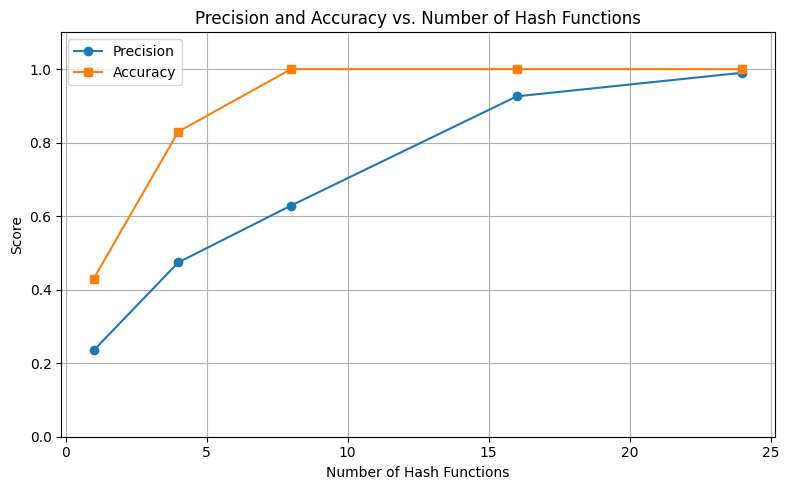

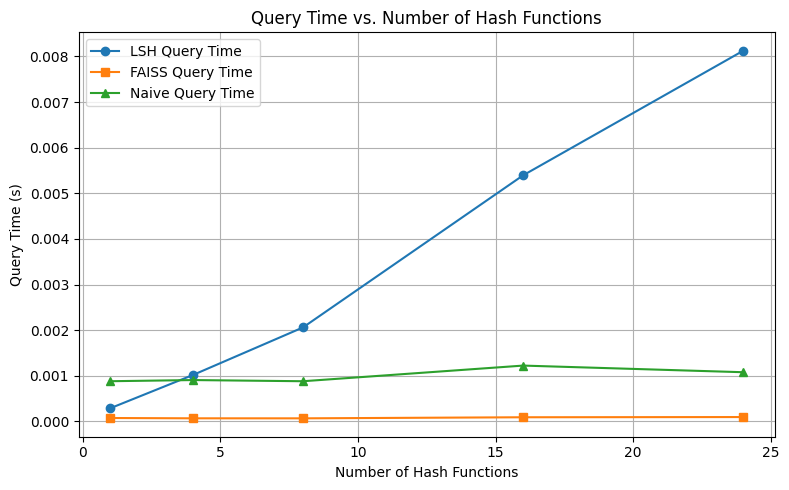

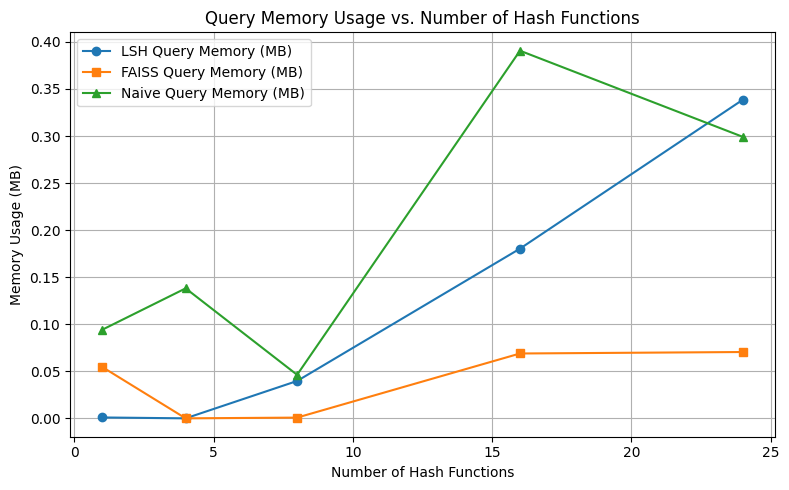

In [652]:
plot_precision_accuracy_vs_num_functions(stats)
plot_query_times(stats)
plot_query_memory(stats)

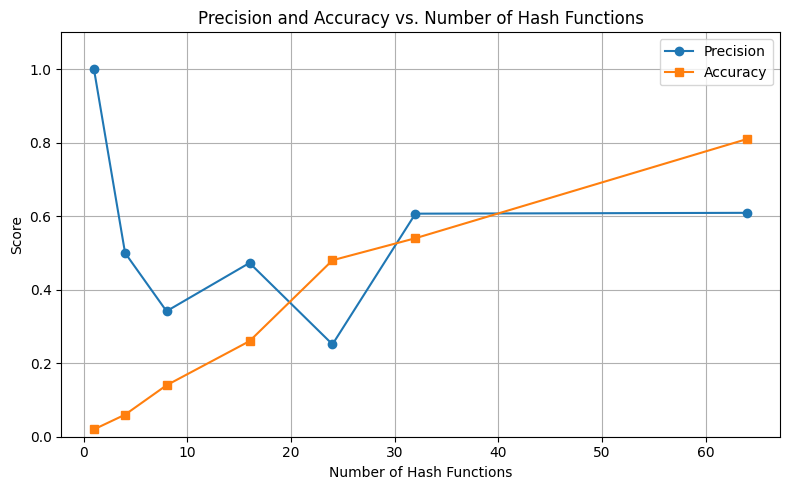

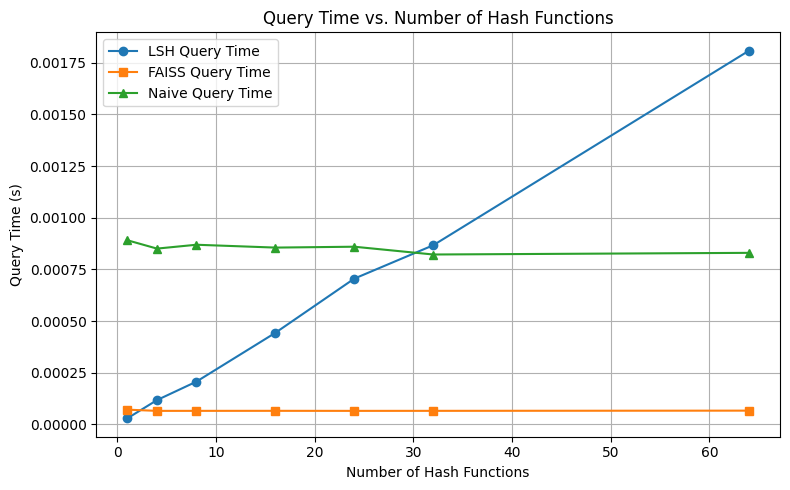

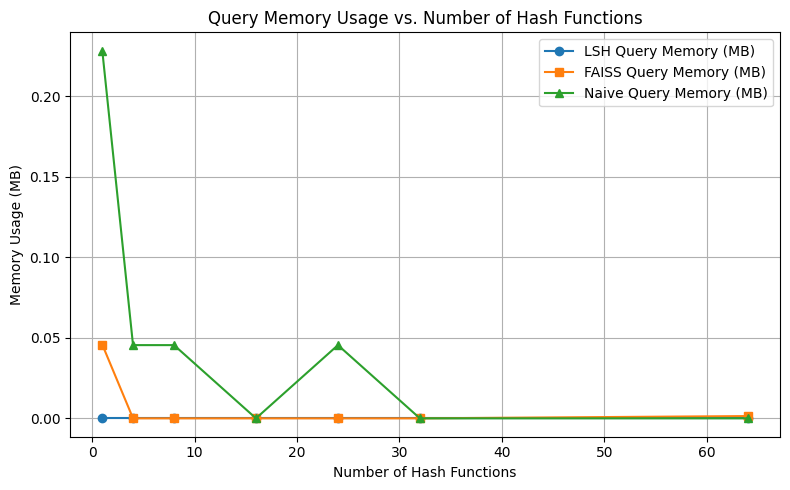

In [455]:
plot_precision_accuracy_vs_num_functions(stats_2)
plot_query_times(stats_2)
plot_query_memory(stats_2)

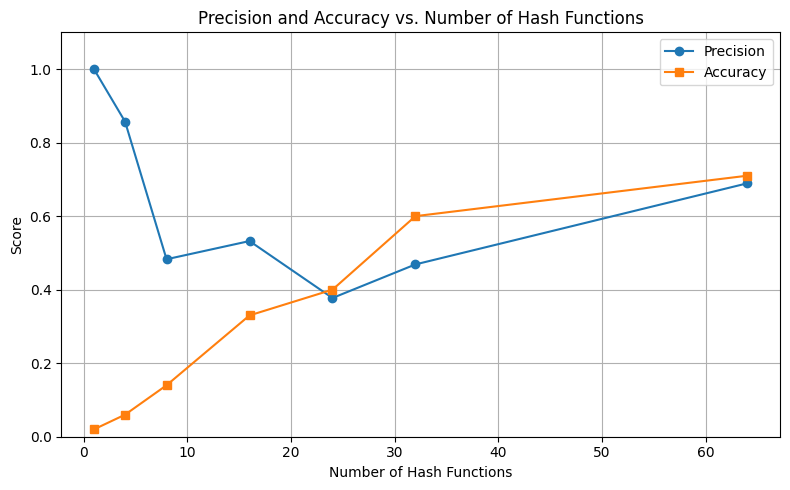

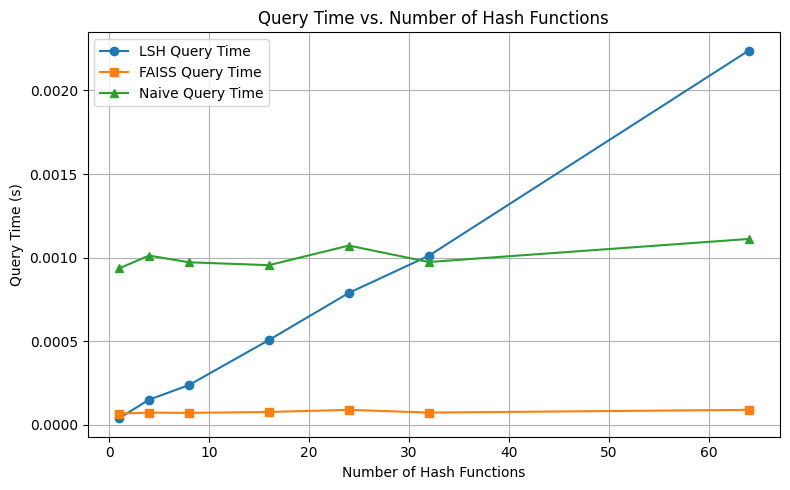

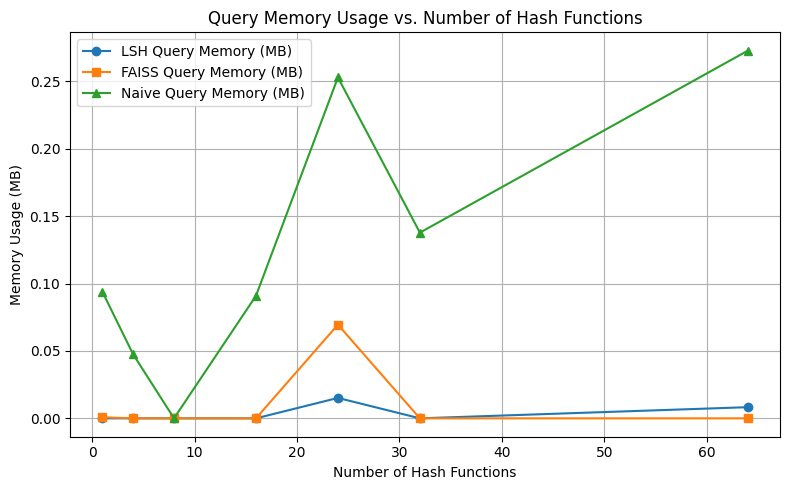

In [653]:
plot_precision_accuracy_vs_num_functions(stats_3)
plot_query_times(stats_3)
plot_query_memory(stats_3)

We observe that our **Spherical LSH** outperform Naive NN in space usage and on par with FAISS

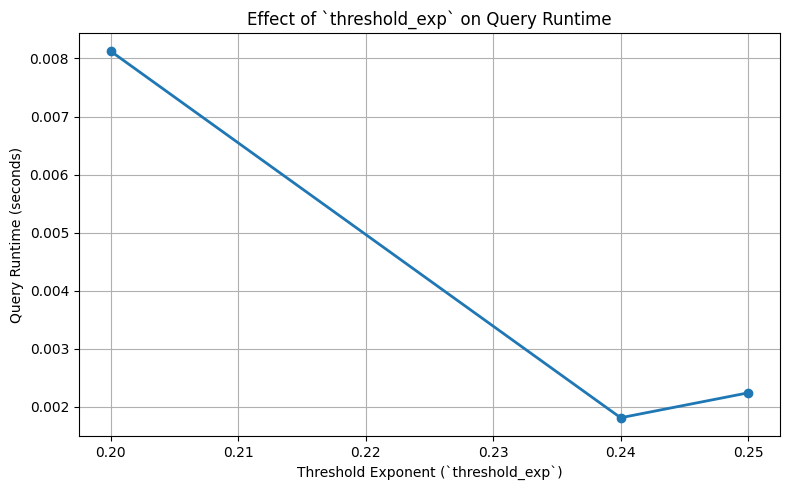

In [660]:
plot_qury_time_vs_threshold_exps([0.2, 0.24, 0.25], [stats, stats_2, stats_3])

We observed the desired decrease in query runtime as the `threshold_exp` getting close to  `0.25`, confirming the theoretical runtime bound.

### 5.2 Results for higher dim embeddings

In [ ]:
h_stats = gather_stats(
    higher_embeddings,
    h_faiss_l2_index,
    num_queries=100,
    num_functions_list=[1, 4, 8, 16, 24, 32],
    threshold_exp = 0.22,
    max_iterations=1000
)

In [ ]:
h_stats_2 = gather_stats(
    higher_embeddings,
    h_faiss_l2_index,
    num_queries=100,
    num_functions_list=[1, 4, 8, 16, 24, 32, 64],
    threshold_exp = 0.22,
    max_iterations= 2000
)

In [ ]:
h_stats_3 = gather_stats(
    higher_embeddings,
    h_faiss_l2_index,
    num_queries=100,
    num_functions_list=[1, 4, 8, 16, 24, 32, 64],
    threshold_exp = 0.22,
    max_iterations= 10000
)

In [ ]:
h_stats_4 = gather_stats(
    higher_embeddings,
    h_faiss_l2_index,
    num_queries=100,
    num_functions_list=[1, 4, 8, 16, 24, 32, 64],
    threshold_exp = 0.225,
    max_iterations= 30000
)

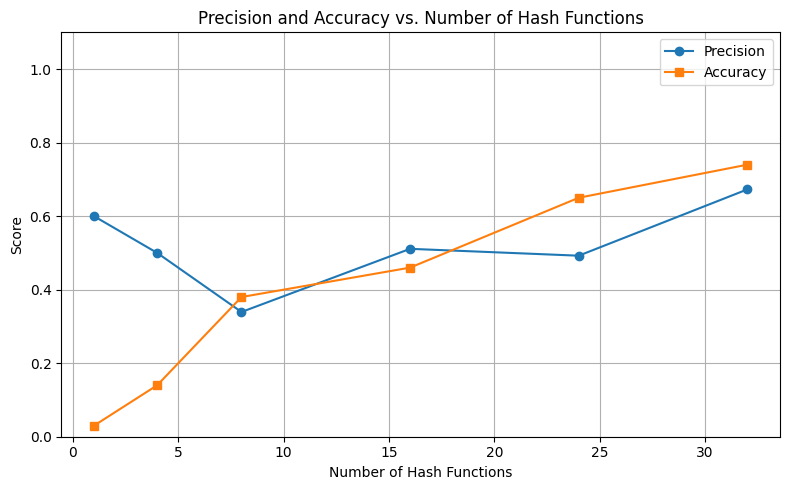

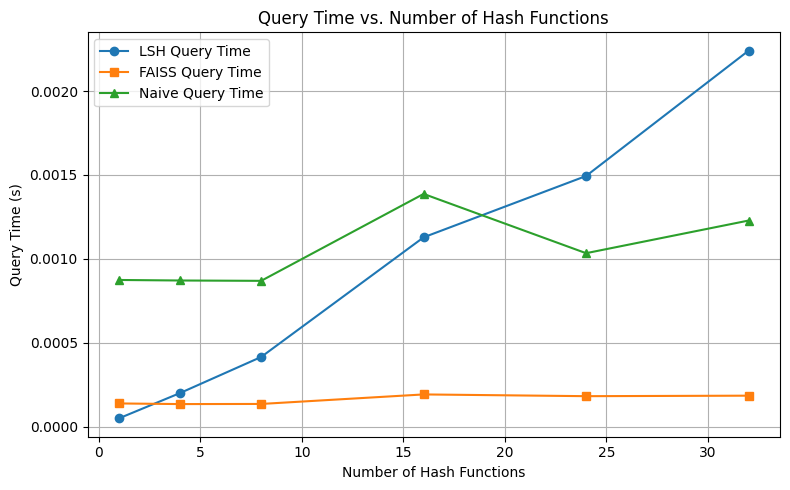

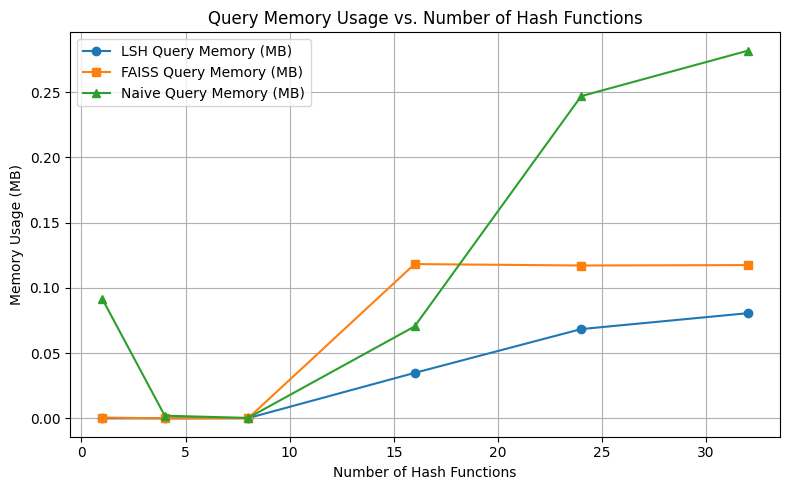

In [443]:
plot_precision_accuracy_vs_num_functions(h_stats)
plot_query_times(h_stats)
plot_query_memory(h_stats)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


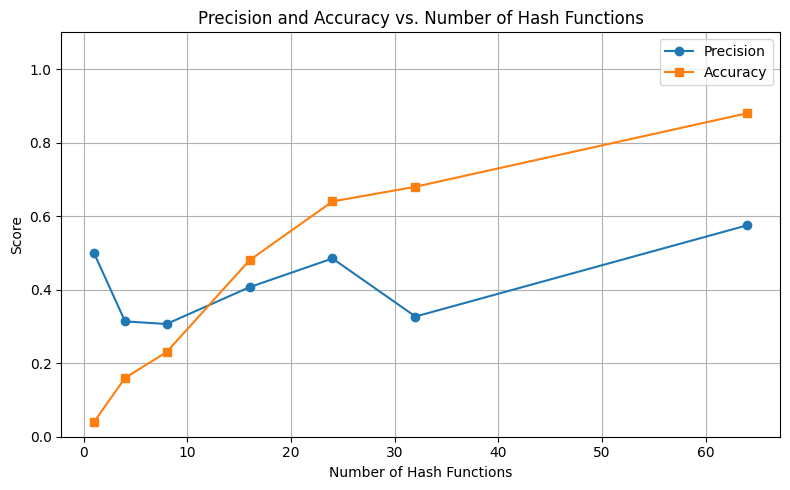

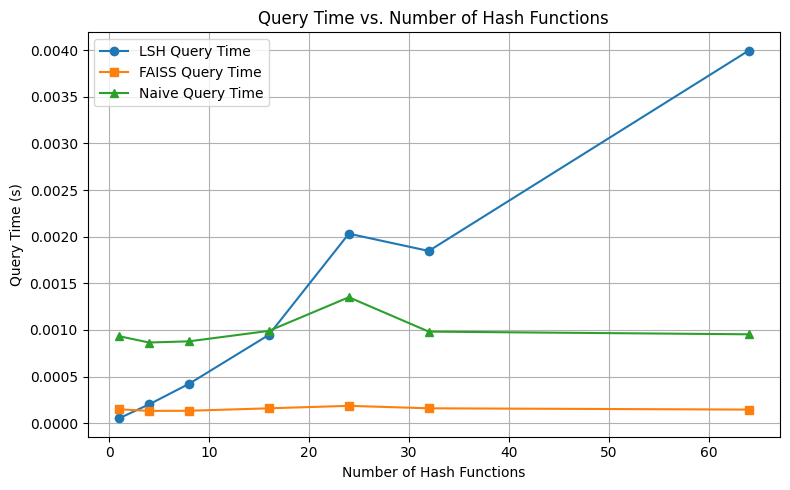

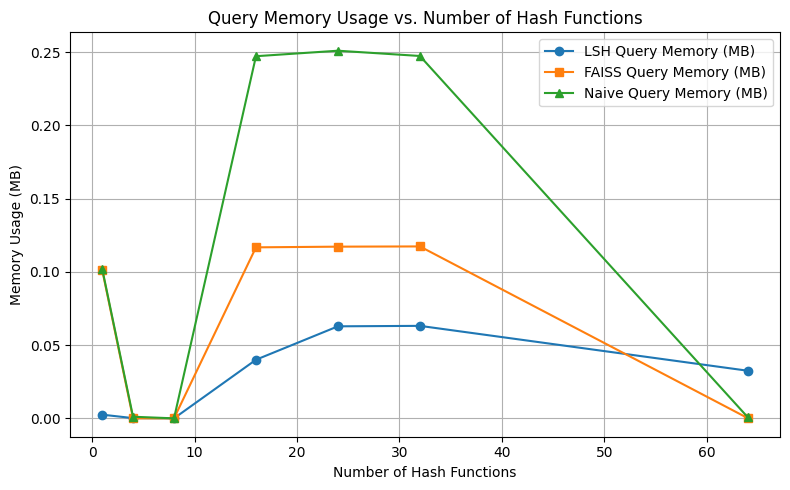

In [448]:
plot_precision_accuracy_vs_num_functions(h_stats_2)
plot_query_times(h_stats_2)
plot_query_memory(h_stats_2)

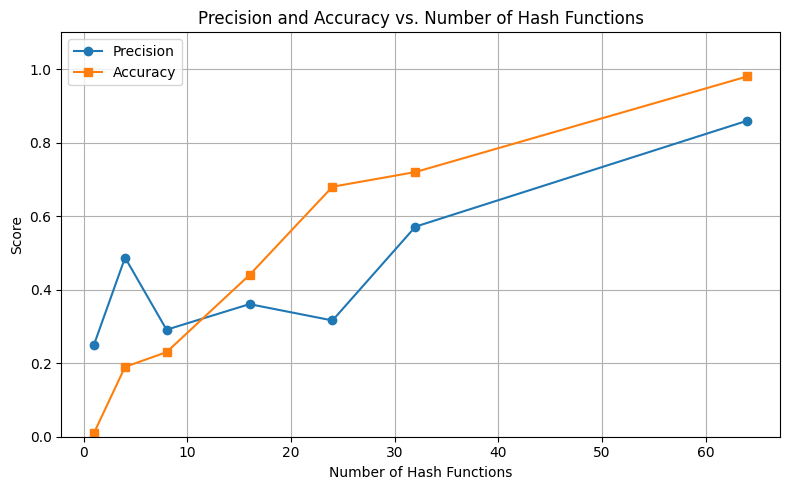

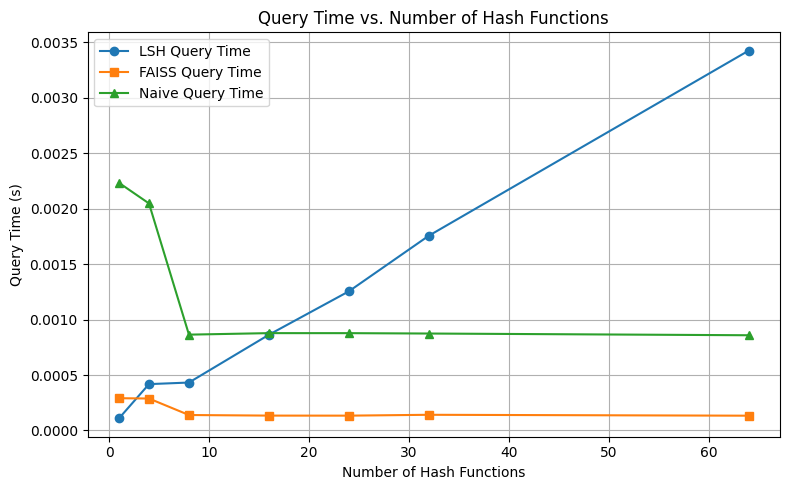

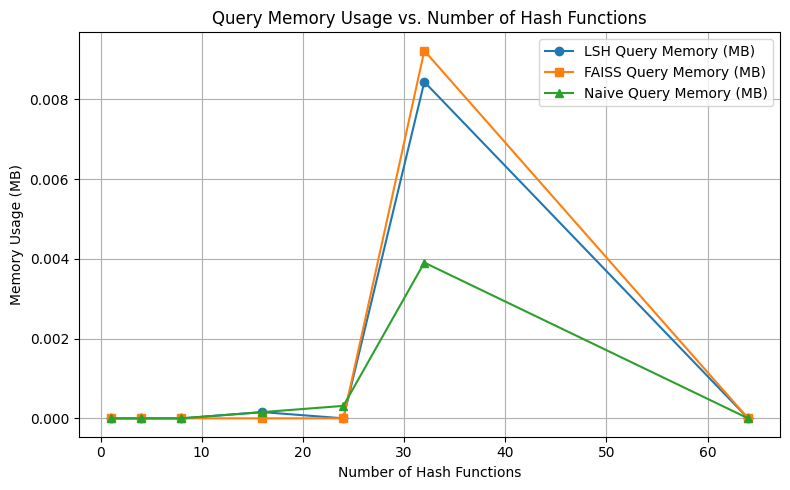

In [655]:
plot_precision_accuracy_vs_num_functions(h_stats_3)
plot_query_times(h_stats_3)
plot_query_memory(h_stats_3)

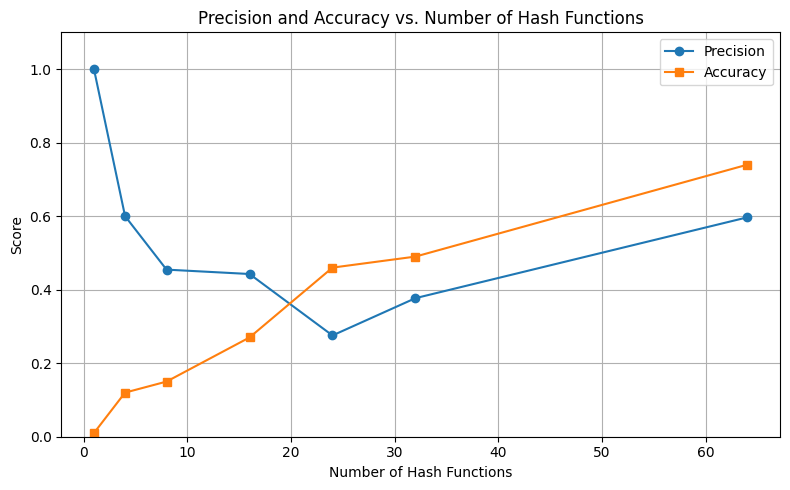

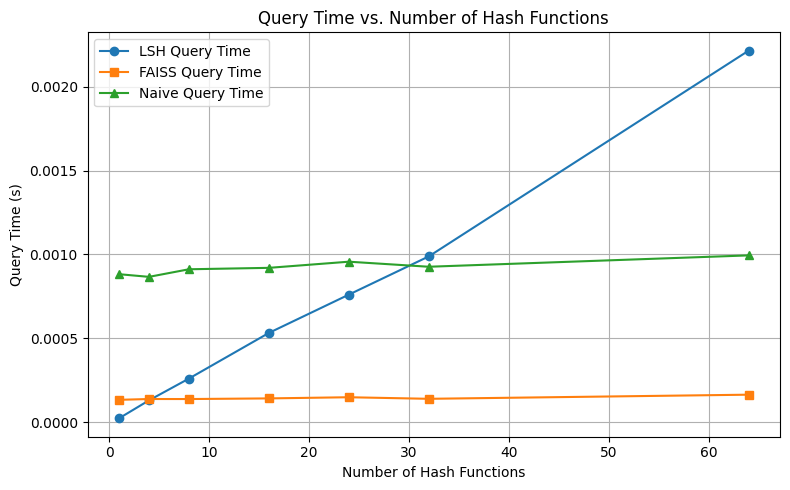

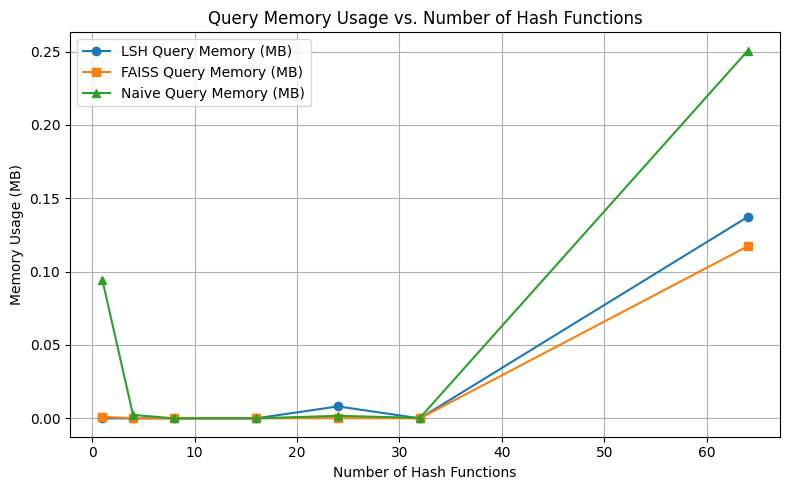

In [654]:
plot_precision_accuracy_vs_num_functions(h_stats_4)
plot_query_times(h_stats_4)
plot_query_memory(h_stats_4)

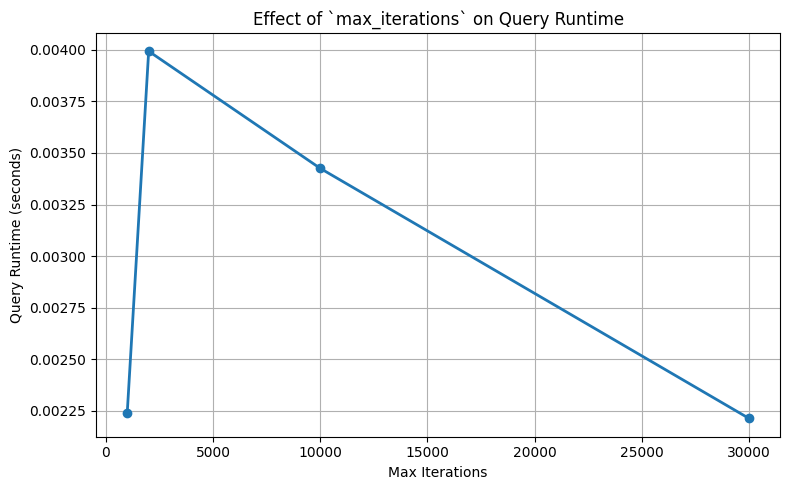

In [662]:
plot_query_time_vs_max_iterations([1000, 2000, 10000, 30000], [h_stats, h_stats_2, h_stats_3, h_stats_4])

Here the `maximum_iterations = 1000` has a lower runtime. This might be because that the Spherical LSH fails to find many paritions so the observed runtime is low. Other than that, we do oberve the expected runtim decrease as we increase the `maximum_iterations` for better approximations so that our observed runtime is closer to the theoretical runtime bound.

## 6 Empirical Observations


- While our Spherical LSH approach shows promising trends and competitive accuracy, **its query runtime still does not outperform FAISS** in our experiments. However, **its memory usage is significantly lower than naive nearest neighbor**, and is **comparable to FAISS** for both lower dim embeddings and higher dim embeddings.

- We observe that **accuracy and precision improve** as the **`number of LSH functions`** increases. This aligns with theoretical expectations, as more partitions allow finer discrimination between nearby vectors.

- When we use a **slackened `threshold_exp`** (i.e., a looser angular threshold for carving caps), we see **better accuracy and precision**. However, this comes at the cost of **higher query time**, diverging from the theoretical sublinear query time bounds. A looser threshold causes more points to fall into the same cap, increasing candidate set size.

- In contrast, using a **stricter `threshold_exp`** results in **smaller candidate sets** and **query times closer to the theoretical bound**. Also, the accuracy is well-maintained again confirming with the theoretical bound for the number of hash functions needed $
  n^\rho \quad \text{where} \quad \rho = \frac{1}{c^2},\quad c > 1
  $

  Consequently, the **theoretical runtime and space complexity** for Spherical LSH becomes:

  $
  O(n^\rho \cdot d) \quad \text{and} \quad O(n^{\rho + 1} \cdot d + n \cdot d)
  $

By implementing **Spherical LSH** and experimenting on real-world course description data, we gained valuable insights into the practical performance of locality-sensitive hashing and the intuition for the theoretical bounds. However, there are also implementation tradeoffs.

- With a stricter `threshold_exp`, our implementation takes significantly **longer to find a valid Spherical LSH partition** while getting closer the the **theoretical bounds**. 